In [1]:
# NOTE: reduced implementation might require slightly different parameters for same results

In [2]:
# Imports
import os
import sys
import h5py
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

In [3]:
# Relative Imports
package_path = Path(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
sys.path.insert(0, str(package_path))

from src.expressive_leaky_memory_neuron import ELM
from src.shd.shd_data_loader import SHD, SHDAdding, random_val_split_SHD_data, visualize_training_batch
from src.shd.shd_download_utils import get_shd_dataset

In [4]:
general_seed = 0
os.environ['PYTHONHASHSEED'] = str(general_seed)
random.seed(general_seed)
np.random.seed(general_seed)
torch.manual_seed(general_seed)
torch.cuda.manual_seed(general_seed)
torch.backends.cudnn.deterministic = True

In [5]:
# Data download config
data_path = "shd_data"
get_shd_dataset("./", data_path)

Available at: ./shd_data/shd_train.h5
Available at: ./shd_data/shd_test.h5


In [6]:
# Dataset config
dataset = "shd" # "shd", "shdadding"
data_seed = general_seed
valid_fraction = 0.2
bin_size = 10
num_classes = 20 if dataset == "shd" else 19
num_input_channel = 700

In [7]:
# Model config
lambda_value = 5.0
num_memory = 100
mlp_num_layers = 1
memory_tau_min = 1.0
memory_tau_max = 500.0
learn_memory_tau = False
delta_t = float(bin_size)

In [8]:
# Training config
learning_rate = 5e-3
num_epochs = 10
batch_size = 8
dropout= 0.5

In [9]:
# Open the downloaded dataset
train_file = h5py.File(os.path.join(data_path, 'shd_train.h5'), 'r')
test_file = h5py.File(os.path.join(data_path, 'shd_test.h5'), 'r')

# Split the dataset into training and validation sets
x_train, y_train, x_valid, y_valid = random_val_split_SHD_data(
    train_file=train_file, 
    valid_fraction=valid_fraction, 
    seed=general_seed
)

# Extract the testing dataset
x_test = test_file['spikes']
y_test = test_file['labels']

# Initialize datasets
if dataset == "shd":
    train_dataset = SHD(X=x_train, y=y_train, batch_size=batch_size, bin_size=bin_size, shuffle=True, test_set=False)
    valid_dataset = SHD(X=x_valid, y=y_valid, batch_size=batch_size, bin_size=bin_size, shuffle=False, test_set=False)
    test_dataset = SHD(X=x_test, y=y_test, batch_size=batch_size, bin_size=bin_size, shuffle=False)
    
    batches_per_epoch = len(train_dataset)
    valid_batches_per_epoch = len(valid_dataset)
    test_batches_per_epoch = len(test_dataset)
else:
    batches_per_epoch = 2000
    valid_batches_per_epoch = 500
    test_batches_per_epoch = 2000

    train_dataset = SHDAdding(X=x_train, y=y_train, batch_size=batch_size, bin_size=bin_size,
                              batches_per_epoch=batches_per_epoch, shuffle=True)
    valid_dataset = SHDAdding(X=x_valid, y=y_valid, batch_size=batch_size, bin_size=bin_size,
                              batches_per_epoch=valid_batches_per_epoch, shuffle=False)
    test_dataset = SHDAdding(X=x_test, y=y_test, batch_size=batch_size, bin_size=bin_size,
                             batches_per_epoch=batches_per_epoch, shuffle=False)

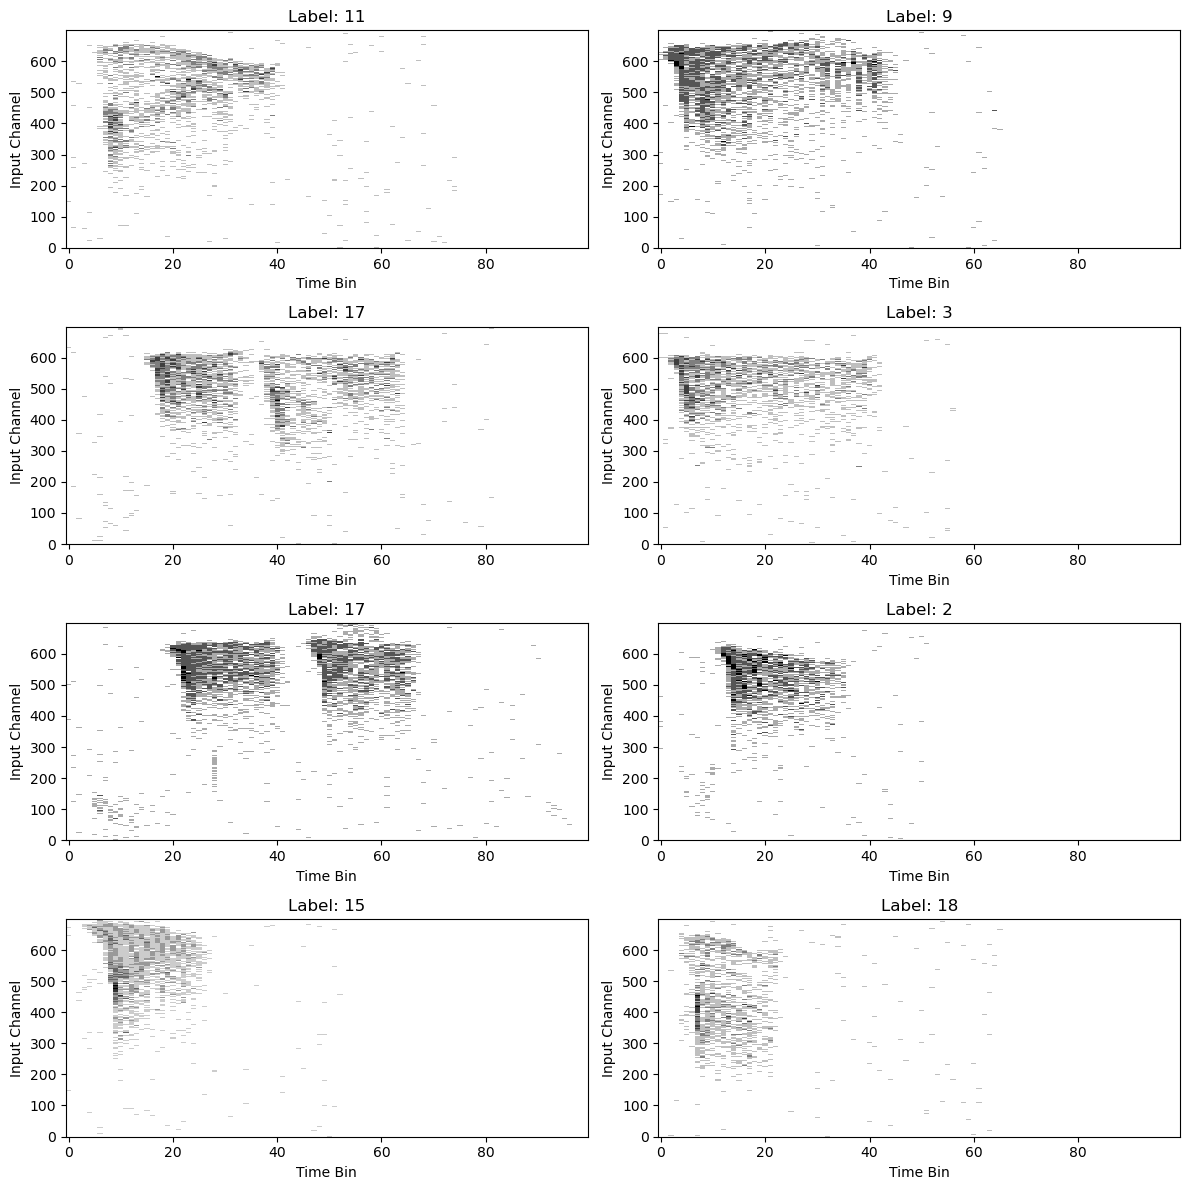

In [10]:
example_batch = next(iter(train_dataset))
visualize_training_batch(example_batch)

In [11]:
# Initialize the ELM model
model = ELM(
    num_input=num_input_channel,
    num_output=num_classes, 
    num_memory=num_memory, 
    mlp_num_layers=mlp_num_layers,
    memory_tau_min=memory_tau_min,
    memory_tau_max=memory_tau_max,
    learn_memory_tau=learn_memory_tau,
    lambda_value=lambda_value, 
    delta_t=delta_t
)

# Initialize the loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)

# Define scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=batches_per_epoch*num_epochs)

In [12]:
# Initialize the best validation accuracy to 0
best_valid_accuracy = 0.0
best_model_state_dict = model.state_dict().copy()

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    pbar = tqdm(enumerate(train_dataset, 0), total=batches_per_epoch)
    for i, data in pbar:
        inputs, labels = data
        
        # Apply dropout
        dropout_mask = torch.rand_like(inputs) < dropout
        inputs[dropout_mask] = 0
        
        # Perform a single training step
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs[:,-1,:] # last time step prediction
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update running loss
        running_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} Loss: {running_loss / (i+1):.3f}")

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    training_accuracy = correct_predictions / total_predictions

    # Validation
    model.eval()
    valid_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for i, data in tqdm(enumerate(valid_dataset, 0), total=valid_batches_per_epoch):
        with torch.no_grad():
            inputs, labels = data
            dropout_mask = torch.rand_like(inputs) < dropout
            inputs[dropout_mask] = 0
        
            outputs = model(inputs)
            outputs = outputs[:,-1,:] # last time step prediction
            loss = criterion(outputs, labels)

        valid_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    validation_accuracy = correct_predictions / total_predictions
    
    # Copy model state dict if validation accuracy has improved
    if validation_accuracy > best_valid_accuracy:
        best_valid_accuracy = validation_accuracy
        best_model_state_dict = model.state_dict().copy()

    # Print statistics
    print(f'Epoch: {epoch+1}, Training Accuracy: {training_accuracy:.2f}, Validation Accuracy: {validation_accuracy:.2f}')

# Load the best model
model.load_state_dict(best_model_state_dict)
    
# Test
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
for i, data in tqdm(enumerate(test_dataset, 0), total=test_batches_per_epoch):
    with torch.no_grad():
        inputs, labels = data
        dropout_mask = torch.rand_like(inputs) < dropout
        inputs[dropout_mask] = 0
        
        outputs = model(inputs)
        outputs = outputs[:,-1,:] # last time step prediction
        loss = criterion(outputs, labels)

    test_loss += loss.item()

    # Calculate accuracy
    _, predicted = torch.max(outputs.data, 1)
    correct_predictions += (predicted == labels).sum().item()
    total_predictions += labels.size(0)

test_accuracy = correct_predictions / total_predictions

# Print statistics
print(f'Test Accuracy: {test_accuracy:.2f}')

100%|█████████████████████████████████████████| 205/205 [00:05<00:00, 37.78it/s]


Epoch: 1, Training Accuracy: 0.25, Validation Accuracy: 0.45


100%|█████████████████████████████████████████| 205/205 [00:05<00:00, 37.49it/s]


Epoch: 2, Training Accuracy: 0.50, Validation Accuracy: 0.58


100%|█████████████████████████████████████████| 205/205 [00:05<00:00, 37.15it/s]


Epoch: 3, Training Accuracy: 0.66, Validation Accuracy: 0.68


100%|█████████████████████████████████████████| 205/205 [00:05<00:00, 37.19it/s]


Epoch: 4, Training Accuracy: 0.78, Validation Accuracy: 0.80


100%|█████████████████████████████████████████| 205/205 [00:05<00:00, 40.12it/s]


Epoch: 5, Training Accuracy: 0.84, Validation Accuracy: 0.86


100%|█████████████████████████████████████████| 205/205 [00:04<00:00, 41.81it/s]


Epoch: 6, Training Accuracy: 0.89, Validation Accuracy: 0.87


100%|█████████████████████████████████████████| 205/205 [00:04<00:00, 42.09it/s]


Epoch: 7, Training Accuracy: 0.92, Validation Accuracy: 0.90


100%|█████████████████████████████████████████| 205/205 [00:05<00:00, 40.09it/s]


Epoch: 8, Training Accuracy: 0.95, Validation Accuracy: 0.93


100%|█████████████████████████████████████████| 205/205 [00:05<00:00, 40.66it/s]


Epoch: 9, Training Accuracy: 0.96, Validation Accuracy: 0.93


100%|█████████████████████████████████████████| 205/205 [00:05<00:00, 39.64it/s]


Epoch: 10, Training Accuracy: 0.96, Validation Accuracy: 0.93


100%|█████████████████████████████████████████| 283/283 [00:07<00:00, 40.12it/s]

Test Accuracy: 0.86
